# 23 - Challenges with Effect Heterogeneity and Nonlinearity

인과추론의 어려운 점은 `potential outcome`의 모든 결과를 알 수 없다는 것입니다. `unit` 수준의 처치 효과(`ground truth`)를 알 방법이 없습니다. 앞 장에서 조건부 처치 효과(`CATE`)를 추정하기 위해 `target transformation`(목표 변환)을 사용하는 방법을 배웠습니다. 목표 변환에서는 과적합으로 인한 문제가 있었습니다. 이는 얻은 인과 모델을 적용할 수 없는 이유가 되기도 하는데, 처치를 개인화하려 할 때 잘못된 결론을 줄 수 있기 때문입니다.

`CATE`를 직접 추정하지 않는 대신 분산이 작은 `target`에 집중한다면 종종 더 나은 방법으로 처치 효과를 개인화할 수 있습니다. 특히 `outcome` $Y$가 `binary`일 때 유용합니다.

## Treatment Effects on Binary Outcomes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from toolz import curry
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

@curry
def avg_treatment_effect(df, treatment, outcome):
    return df.loc[df[treatment] == 1][outcome].mean() - df.loc[df[treatment] == 0][outcome].mean()  

@curry
def cumulative_effect_curve(df: pd.DataFrame,
                            treatment: str,
                            outcome: str,
                            prediction: str,
                            min_rows: int = 30,
                            steps: int = 100,
                            effect_fn = avg_treatment_effect) -> np.ndarray:
    
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([effect_fn(ordered_df.head(rows), treatment, outcome) for rows in n_rows])

@curry
def cumulative_gain_curve(df: pd.DataFrame,
                          treatment: str,
                          outcome: str,
                          prediction: str,
                          min_rows: int = 30,
                          steps: int = 100,
                          effect_fn = avg_treatment_effect) -> np.ndarray:

    size = df.shape[0]
    n_rows = list(range(min_rows, size, size // steps)) + [size]

    cum_effect = cumulative_effect_curve(df=df, treatment=treatment, outcome=outcome, prediction=prediction,
                                         min_rows=min_rows, steps=steps, effect_fn=effect_fn)

    return np.array([effect * (rows / size) for rows, effect in zip(n_rows, cum_effect)])


테크 기업에서 직면하는 일반적인 문제를 생각해봅시다. 경영진은 일종의 넛지 효과로 제품 구매율을 높이고 싶습니다. 예를 들어 인앱 결제로 편하게 제품을 구매하도록 $10$ BRL만큼 혜택을 제공해 앱 설치 수를 늘리거나, 추천인에 대한 혜택을 제공하거나, 처음 3개월 동안 무료 배송 혜택을 주려 합니다. 넛지 효과를 만드는 방법은 비용이 많이 들어 경영진은 일부 민감한 고객에게만 혜택을 주려 합니다.
 
인과 추론에 능한 여러분이라면 이 문제의 목표가 `treatment effect heterogeneity`(`TEH`, 처치 효과 이질성)를 구하는 것임을 이미 아실겁니다. `treatment` $T$는 넛지 효과를 주는 행위, `outcome` $Y$는 구매 전환, `feature` $X$는 사전에 가지고 있는 고객 데이터입니다. `Double/Debiased ML` 같은 방법으로 조건부 평균 처치 효과 $E[Y_1 - Y_0|X]$ (처치가 연속이면 $E[Y'(T)|X]$)를 추정하고 처치 효과가 큰 고객을 대상으로 구매를 독려할 수 있습니다. 비즈니스 용어로는 **전환 전략을 개인화**할 수 있습니다. 즉, 구매 전환율이 높은 고객을 대상으로만 넛지 전략을 사용합니다.
 
하지만 `outcome`이 `binary`일 때는 `TEH`를 구하기가 어렵습니다. 바로 이해하기는 어렵습니다. 어떤 문제가 발생하는지 먼저 보고 왜 문제가 발생하는지 말씀드리겠습니다.

## Simulating Some Data
 
시뮬레이션으로 데이터를 만들어 봅시다. `treatment`인 `nudge`를 $p=0.5$인 베르누이 분포에서 추출하여 무작위로 할당합니다. 마치 동전 던지기와 같습니다. 무작위 할당이므로 교란 요인은 더 이상 생각하지 않아도 됩니다.
 
$ nudge \sim \mathcal{B}(0.5) $
 
다음은 감마 분포를 사용해 고객의 `covariate`(공변량)인 `age`와 `income`을 할당합니다. `age`와 `income`은 이미 알고 있는 고객 정보로 이를 기반으로 개인화하고자 합니다. 즉, `age`와 `income`으로 정의된 고객 그룹 중 `nudge`에 민감한 그룹을 찾습니다.
 
$ age \sim G(10, 4) $
 
$ income \sim G(20, 2) $
 
마지막으로 구매 전환 데이터를 시뮬레이션합니다. 데이터를 만들기 위해 **무작위 잡음이 포함된 선형 잠재 변수를 만듭니다.** 중요한 점은 `income`은 $Y_{latent}$을 잘 따르지만 **처치 효과를 바꾸지 않는다는 것입니다.** 간단히 말해 `nudge`는 모든 수준의 `income`에 대해 $Y_{latent}$를 똑같이 바꿉니다. 반대로 `age`는 `nudge`와 상호작용하는 방법으로만 $Y_{latent}$에 영향을 줍니다. $Y_{latent}$는 아래 수식과 같이 평균이 `age`, `income`, `nudge`의 선형 결합, 분산이 $1$인 정규분포를 따릅니다.
 
$Y_{latent} \sim N(-4.5 + 0.001 \times income + nudge + 0.01 \times nudge \times age, 1)$
 
$Y_{latent}$를 구하고 기준값 $x$를 사용해 `conversion`을 얻을 수 있습니다. ($conversion = 1\{Y_{latent} > x \}$). `conversion` 비율이 대략 $50$%가 되도록 $x=0$으로 설정합니다. 즉, 평균적으로 50%의 고객은 `nudge`가 구매로 이어집니다.

In [2]:
np.random.seed(123)

n = 100000
nudge = np.random.binomial(1, 0.5, n)
age = np.random.gamma(10, 4, n)
estimated_income = np.random.gamma(20, 2, n)*100

latent_outcome = np.random.normal(-4.5 + estimated_income*0.001 + nudge + nudge*age*0.01)
conversion = (latent_outcome > .1).astype(int)

편의상 모든 데이터를 데이터프레임으로 만듭니다. 추가로 `conversion` 평균값이 실제로 $50$%에 가까운지 확인해봅시다.

In [3]:
df = pd.DataFrame(dict(conversion=conversion,
                       nudge=nudge,
                       age=age,
                       estimated_income=estimated_income,
                       latent_outcome=latent_outcome))

df.mean()

conversion             0.518260
nudge                  0.500940
age                   40.013487
estimated_income    3995.489527
latent_outcome         0.197076
dtype: float64

처치가 무작위이므로 `ATE`는 실험군과 대조군의 단순한 평균 차이로 추정할 수 있습니다. ($E[Y|T=1] - E[Y|T=0]$) 먼저 `latent_outcome`, `conversion`에 대한 `ATE`를 계산합니다.

In [4]:
df.groupby("nudge")[["latent_outcome", "conversion"]].mean()

,latent_outcome,conversion
nudge,,
0,-0.505400,0.320503
1,0.896916,0.715275


In [5]:
avg_treatment_effect(df, "nudge", "latent_outcome")

1.4023163965477656

In [6]:
avg_treatment_effect(df, "nudge", "conversion")

0.39477273768476406

`latent_outcome`에 대한 `ATE`는 쉽게 이해할 수 있습니다. 데이터 생성 방법에 따라 처치 효과는 $1 + 0.01 \times avg(age)$이라는 사실을 알고 있습니다. 평균 나이가 40세 정도이므로 `ATE`는 거의 $1.4$입니다. `conversion`에 대한 `ATE`는 더 복잡하지만 재미있습니다. **conversion은 0과 1 사이로 제한되어 있어 ATE는 선형이 아닙니다.** 따라서 `latent_outcome`처럼 공식을 통해 `ATE`를 얻을 수 없습니다. 실제로는 가능하지만, 꽤 복잡합니다. 그냥 숫자가 작은 것으로 생각하고 넘어갑니다. 제 말은 `conversion`이 $100$%를 넘을 수 없으므로 `nudge`가 `conversion`을 $1.4$만큼 늘릴 방법이 없다는 의미입니다. 이 사실은 뒤 내용을 이해하는데 중요하므로 기억해 둡시다.
 
이제 `CATE`(조건부 평균 처치 효과)를 알아보겠습니다. 데이터 생성 과정에 따라 `income`으로 `conversion`을 예측할 수 있지만, `nudge` 효과를 바꾸지는 않습니다. 따라서 `income`을 기준으로 고객 그룹을 나누면 모든 그룹이 같은 처치 효과를 갖습니다. 반면 `age`는 `nudge`와 상호작용으로만 `conversion`에 영향을 줍니다. 따라서 `age`는 처치에 따라 다르게 반응합니다. 즉, `income`은 좋은 개인화 변수가 아니며, `age`는 좋은 개인화 변수입니다.
 
누적 효과 곡선으로 이를 확인할 수 있습니다. `age` 곡선은 `ATE`로부터 먼 곳에서 `ATE`로 천천히 수렴해야 하며, `income` 곡선은 `ATE`를 중심으로 움직일 것입니다. `latent_outcome`에서는 예상한 결과를 확인할 수 있습니다.

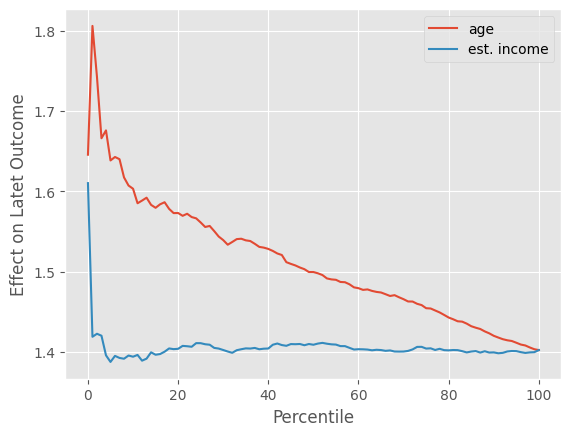

In [7]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "latent_outcome", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Latet Outcome");

`latent_outcome`에 대한 결과는 매우 좋습니다. 선형성에 의해 예상한 결과가 그대로 나타납니다. 하지만 `latent_outcome`은 관심 대상이 아닙니다. `conversion`에 더 관심이 있습니다. `conversion`에 대해서는 상황이 복잡해집니다. 누적 효과 곡선에서 `age`는 여전히 `ATE`보다 큰 데서 시작해 서서히 `ATE`로 수렴하는 처치 효과 이질성을 보여줍니다. `age`가 높을수록 처치 효과가 높습니다. 지금까지는 예상한 그대로입니다.

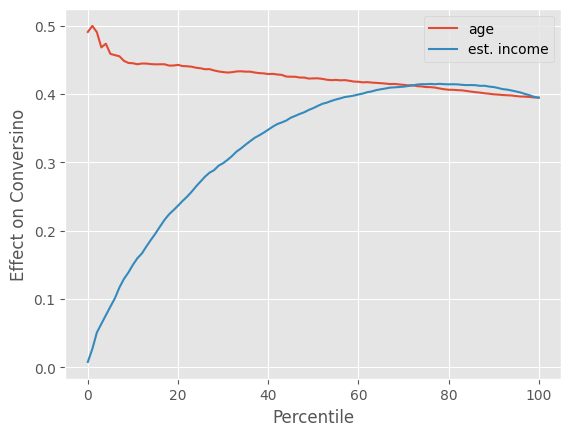

In [8]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");

하지만 `income`에 대한 처치 효과 이질성도 커 보입니다. `income`이 높은 고객은 처치 효과가 훨씬 작으므로 누적 효과 곡선은 $0$에서 시작해 서서히 `ATE`로 수렴합니다. 이 결과는 `income`이 `age`보다 개인화에 유용한 변수라는 사실을 말해줍니다.

불편하지 않나요? 처치 효과 이질성을 유도하기 위한 `age`가 처치 효과에 영향을 주지 않는 `income`과 비교해 개인화에 더 나쁜 이유는 무엇일까요? 정답은 `conversion`의 **비선형성**에 있습니다. 비록 `income`은 `latent outcome`에 대해 `nudge`의 영향을 바꾸지 않지만, `latent outcome`을 변환하면 영향을 줄 수 있습니다. 선형 변환이 아니기 때문입니다. 따라서 **미분값이 달라집니다.** `conversion`의 최댓값은 $1$이므로 이미 매우 높은 상태라면 증가하기 어렵습니다. 즉, `conversion`이 클 때 미분값은 매우 작습니다. 반면 `conversion`의 최솟값은 $0$이므로 매우 낮은 `conversion`에 대해서도 미분값이 매우 작습니다. 따라서 `conversion`은 양쪽 끝에 작은 미분값을 가지는 `S`모양을 따릅니다. `income`을 $100$개 그룹으로 나누어 개별 그룹 내 평균 `conversion`을 그려보면 `S`모양을 확인할 수 있습니다.

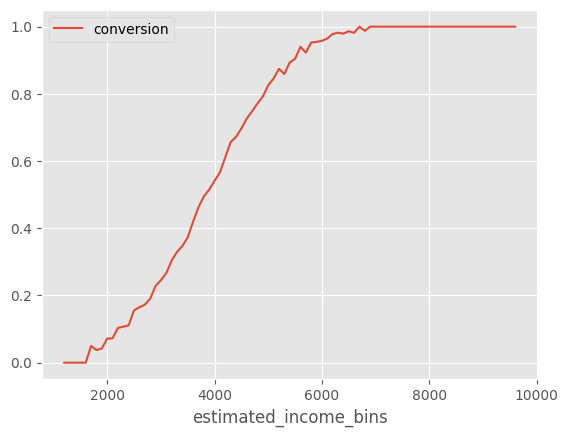

In [9]:
(df
 .assign(estimated_income_bins=(df["estimated_income"]/100).astype(int)*100)
 .groupby("estimated_income_bins")
 [["conversion"]]
 .mean()
 .plot()
);

`conversion`이 클 때, 곡선의 기울기(미분값)는 매우 낮습니다. 작을 때도 마찬가지 입니다. (데이터 수가 적어 명확히 보이지는 않습니다) 이제 `income`이 처치 효과 이질성이 높은 그룹을 만드는 이유를 설명할 수 있습니다.
 
`income`으로 `conversion`을 잘 예측할 수 있으므로 `income`이 다른 고객은 `S`자 곡선에서 다른 위치에 있다고 볼 수 있습니다. `income`이 매우 높거나 낮은 고객은 기울기가 낮은 극단에 해당하며, `conversion`을 바꾸기 어렵습니다. 따라서 처치 효과가 작을 가능성이 높습니다. 반면 `income`이 중간 수준의 고객은 미분값이 높은 구간에 해당하므로 처치 효과 또한 클 가능성이 높습니다. 비선형 함수를 통과할 때 보이는 미분값보다 클 정도로 강력하게 처치 효과를 수정할 수 있기 때문이라 생각합니다. 제 경험상 `S`형 변환은 우리가 가진 다른 모든 효과보다 큰 영향을 줍니다.

저만 이러한 주장을 하는 것은 아닙니다. 아래는 콜롬비아 데이터 과학 연구소에서 발표된 `Susan Athey`의 슬라이드에서 발췌한 그림입니다. `Susan Athey`는 대학 학비를 충당하기 위해 정부 지원 신청을 유도하는 것의 효과를 논의하고 있습니다. 이 또한 `conversion` 문제입니다. `Susan Athey`가 발견한 최고의 전략은 `conversion` 가능성이 있는 학생을 대상으로 신청을 유도하는 것입니다. 또한, `conversion` 가능성이 낮은 사람을 대상으로 지원 신청을 유도하는 것은 나쁜 생각이라 주장합니다.
 
![image.png](data/img/hte-binary-outcome/slide-susan-athey.png)
 
잠깐만요! 당신이 처음 주장한 것과 다른데요? `conversion`이 매우 높거나 낮으면 미분값이 낮으므로 처치 효과 또한 낮다고 하지 않았나요?
 
음... 맞습니다. 하지만 실제로 `conversion`이 전체 `S`형 곡선을 포함하는 경우는 거의 없습니다. 보통은 곡선의 한쪽 끝에 몰려있습니다. 비즈니스 측면에서 평균 `conversion`이 $50$%인 경우는 거의 없습니다. $70~90$%나 $1~20$% 정도인 경우가 많습니다. 이러한 상황에서는 기준이 높은 사람을 대상으로 처치 하는 것이 좋을 수 있습니다.

문제를 다시 한번 살펴보겠습니다. `latent_outcome`은 그대로 하되 `conversion`은 `latent_outcome`이 $2$ 이상으로 설정해 평균적으로 `conversion`이 낮은 상황을 만듭니다. 또한, `latent_outcome > -2`로 설정해 `conversion`이 높은 상황도 만들어 봅시다.

In [10]:
df["conversion_low"] = conversion = (latent_outcome > 2).astype(int)
df["conversion_high"] = conversion = (latent_outcome > -2).astype(int)

print("Avg. Low Conversion: ", df["conversion_low"].mean())
print("Avg. High Conversion: ", df["conversion_high"].mean())

Avg. Low Conversion:  0.12119
Avg. High Conversion:  0.9275


비선형 성질에 따라 무슨 일이 생길지 이해해봅시다. `conversion`이 낮은 상황에서는 높은 기준의 `conversion`(높은 `income`)이 효과적입니다. 이미 `S`자 곡선의 왼쪽에 있으므로 기준이 낮을수록 미분값 또한 작아집니다. **높은 기준은 높은 처치 효과**가 됩니다. 따라서 기준이 높은 고객(높은 `income`)에게 집중해야 합니다.

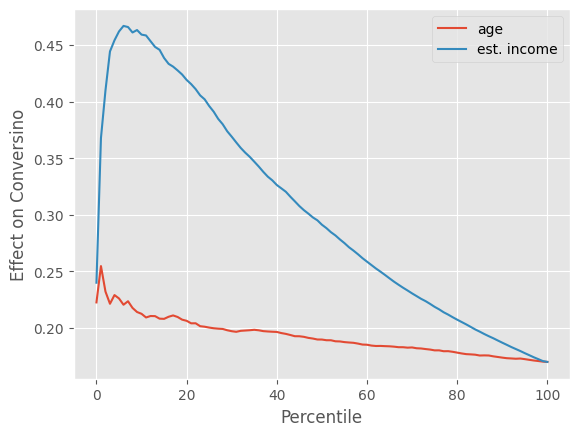

In [11]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_low", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");
plt.legend();

예상한 것처럼 높은 `income`을 가진 사람에 대한 처치 효과가 큽니다.
 
`conversion`이 높은 상황에서는 **기준값이 높을수록 처치 효과가 작습니다.** 이때는 `income`이 높은 고객을 상대하는 것은 좋지 않습니다. 역 누적 효과 곡선으로 `income`이 낮을수록 처치 효과가 커진다는 사실을 알 수 있습니다.

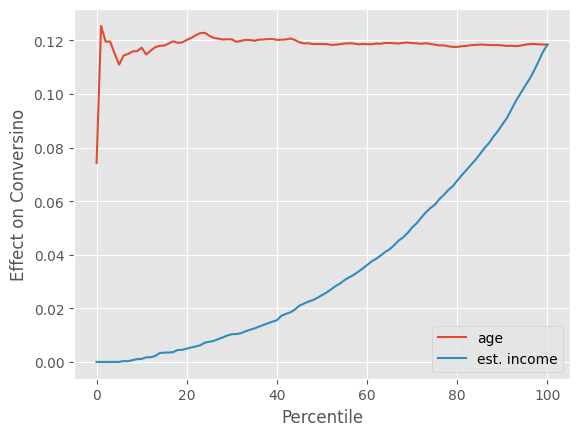

In [12]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_high", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino")
plt.legend();

`binary outcome`인 상황에서는 처치 효과가 로지스틱 함수의 곡률(미분값)로 정해지는 경향이 있습니다.

![image.png](data/img/hte-binary-outcome/logistic.png)
 
예를 들어, `conversion` 문제에서 **평균 conversion이 낮으면 로지스틱 곡선의 왼쪽에 있으며 처치 효과는 높은 기준선에서**에서 더 높습니다. 따라서 전환 가능성이 이미 높은 고객을 처치(`nudge`)하는 것을 옹호하는 정책을 만들 수 있습니다. 반면 **평균 conversion이 높은** 경우 로지스틱 곡선의 오른쪽에 있게 되며, 여기서 미분값(처치 효과)은 낮은 기준에서 높습니다.

기억해야 할 것이 많지만 다음과 같이 단순하게 표현됩니다. **50%에 가까운 고객에게 집중하세요.** 수학적 주장은 상당히 확고합니다. 로지스틱 함수의 도함수는 $50$%에서 최댓값이므로 이 주변의 `unit`을 중요하게 다루어야 합니다.

더욱 멋진 점은 상식과 수학이 일치하는 드문 경우 중 하나라는 것입니다. 일반적으로 마케팅 분야에는 손실 베팅(전환 확률이 낮은 고객)이나 확실한 승리(전환 확률이 높은 고객)를 대상으로 하면 안 된다는 믿음이 있습니다. 즉, 중간의 고객을 목표로 해야 합니다. 이 믿음은 인과관계를 파악하여 얻은 결론과 정확하게 같아 꽤 흥미롭습니다.

# Continues Treatment and Non Linearity
 
앞에서 이종 처치 효과 분석을 어렵게 만드는 상황을 이진 결과 예시로 자세히 살펴보았습니다. 마케팅 분야의 구매 전환에만 문제가 있는 것은 아닙니다. $2021$년, COVID19 백신이 처음으로 생산되었습니다. 당시 누구에게 백신을 먼저 제공할지 결정하는 것은 중요한 문제였습니다. 이 또한 `TEH` 문제입니다. 보건 전문가들은 가장 효과가 큰 사람들에 백신을 먼저 제공했습니다. 백신의 효과는 사망이나 입원을 막는 것입니다. 어떤 사람들에 효과가 컸을까요? 대부분 국가에서 노인이나 나쁜 건강 상태를 가진 사람에게 효과가 컸습니다. 이들은 **COVID19에 걸리면 사망할 가능성이 높은** 사람들입니다. 다행히도 COVID19 사망률은 $50$%보다 훨씬 낮으며, 로지스틱 함수 왼쪽에 위치합니다. 구매 전환 예시에서 주장한 것과 마찬가지로 COVID19에 걸렸을 때 사망할 가능성이 높은 사람들에 먼저 백신을 제공하는 것은 타당해 보입니다. 우연의 일치일까요? 아마도요. 저는 보건 전문가가 아니기 때문에 틀릴 수도 있습니다. 하지만 논리적으로 말이 된다고 생각합니다.

구매 전환과 COVID19 모두 **결과 함수의 비선형성**으로 처치 효과 이질성 분석이 복잡해집니다. 앞에서 살펴본 로지스틱 함수는 종종 나타나는 패턴입니다. 특히 연속형 처치에서 계속해서 나타납니다. 마지막으로 하나의 예시를 더 살펴보겠습니다.

고전적인 가격 문제를 풀어봅시다. 당신은 넷플릭스나 HBO와 같은 스트리밍 회사에서 일합니다. 당신은 고객에게 얼마의 비용을 청구해야 하는지 정하고 싶습니다. 당신은 고객들이 가격 인상에 얼마나 민감한지, 어떤 유형의 고객들이 더 민감한지 알아보기 위해 무작위 고객을 대상으로 $5$ BLR/월, $10$ BRL/월, $15$ BRL/월, $20$ BRL/월 등 다양한 비용을 할당하는 실험을 했습니다. 그 결과 아래 그림과 같이 소득이 높은 고객 `A`와 소득이 낮은 고객 `B`를 나눌 수 있었습니다.

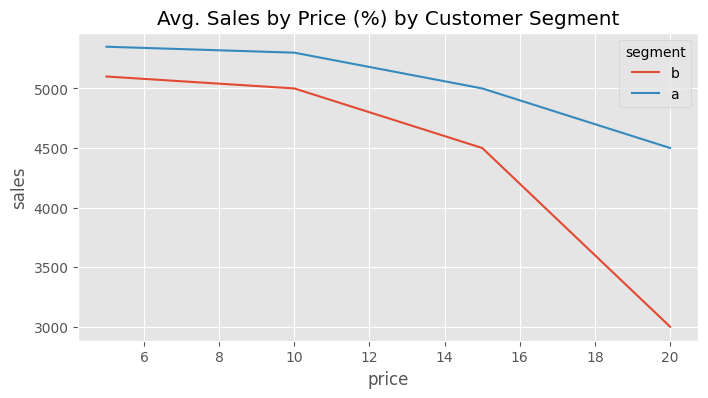

In [13]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

데이터로 가격 할인에 더 민감한 사람을 찾아봅시다. 어떻게 **가격 민감도로 고객을 구분**할 수 있을까요? 그림에서는 고객 `A`가 `sales`(판매량)은 높지만, 할인에 덜 민감한 것 같습니다. 또한, 약간의 곡률도 보입니다. 곡률을 고려하면 처치 효과는 곡선의 위치에 따라 달라집니다. 예를 들어 고객 `A`에 대한 $15$ BRL에서 $10$ BRL까지의 처치 효과는 고객 `B`에 대해 $5$ BRL에서 $10$ BRL까지의 처치 효과보다 높습니다.
 
$$
E[Y(10) - Y(5) | Seg=B] < E[Y(15) - Y(10) | Seg=A]
$$
 
위치에 따라 처치 효과를 구하면 아래 그림과 같습니다.

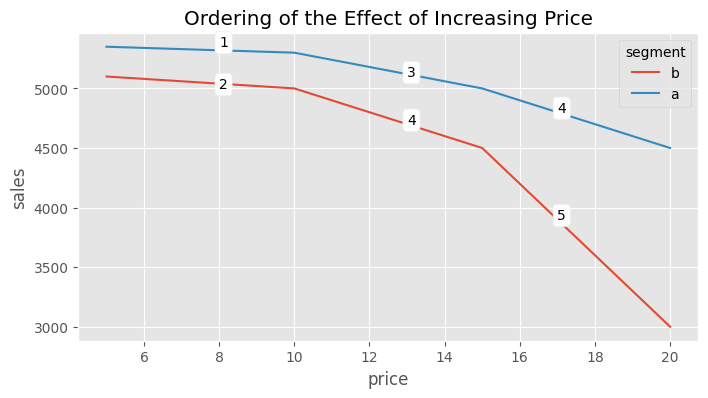

In [14]:
plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")

plt.annotate("1", (8, 5350), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("2", (8, 5000), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("3", (13, 5100), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (13, 4700), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (17, 4800), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("5", (17, 3900), bbox=dict(boxstyle="round", fc="1"))

plt.title("Ordering of the Effect of Increasing Price");

이진 결과와 마찬가지로 **처치 효과는 결과와 관련 있습니다.** 가격이 낮을수록 절대적인 처치 효과는 작습니다. 이 경우 **처치 효과가 결과 외에도 아니라 처치 수준**과 관련 있어 상황은 더 복잡합니다. 이는 반사실적인 질문에 대한 대답을 어렵게 합니다. 잠시 실험 데이터가 아래와 같이 고객 `A`에 대해서는 높은 가격을 포함해 실험하지만, 고객 `B`에 대해서는 낮은 가격만 실험한다고 해봅시다. 회사는 합리적으로 실험하려 하므로 일반적으로 발생하는 상황입니다.

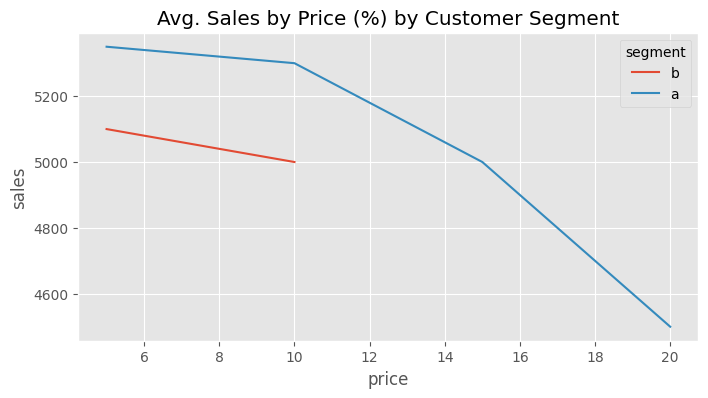

In [15]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data.loc[lambda d: (d["segment"] == "a") | (d["price"] < 12) ], x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

이제 처치 효과를 구하면 고객 `A`가 고객 `B`보다 가격 상승에 훨씬 탄력적으로 보일 것입니다. 하지만 이는 고객 `B`에 대해 낮은 가격에서만 실험했기 때문입니다.
 
처치와 결과에 따라 처치 효과가 달라지면 어떻게 문제를 해결할 수 있을까요? 솔직히 말하면 아직 연구 중인 분야입니다. 현재로서는 **매우 주의**하는 것이 최선입니다. 비교하는 대상의 분포가 같은지 확인해야 합니다. 만약 분포가 다르다면 추정한 처치 효과를 의심해야 합니다. 위 예시에서는 고객 `B`가 가격 인상에 덜 민감해 보이지만 $10$ BRL 이상의 높은 가격도 구매할지는 알 수 없습니다.
 
반응 곡선을 선형화하는 방법도 있습니다. 아이디어는 처치와 결과를 변형시켜 곡선을 제거해 선형 관계처럼 만드는 것입니다. 직선은 기울기가 일정하므로 위치에 따라 처치 효과가 달라지는 문제가 없습니다. 가격 변수를 음수로 만들고 $4$제곱하면 어느 정도 선형 관계를 얻을 수 있습니다. 변환된 데이터에서는 가격에 따라 효과가 달라지지 않기 때문에 `A`가 `B`보다 가격 인상에 덜 민감하다는 주장이 더 설득력 있게 들립니다.

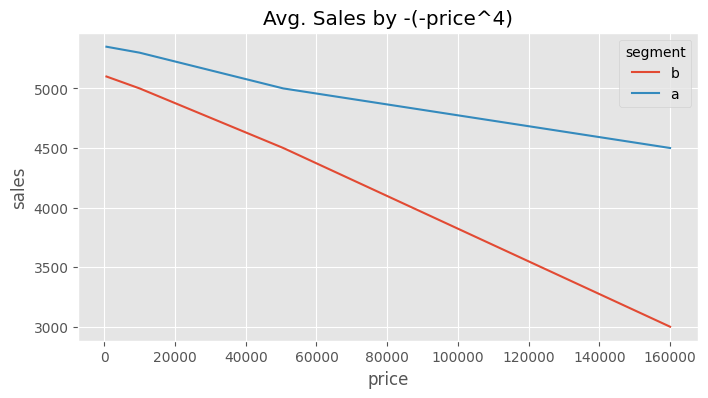

In [17]:
plt.figure(figsize=(8,4))
sns.lineplot(data=data.assign(price = lambda d: -1*(-d["price"]**4)),
             x="price", y="sales", hue="segment")
plt.title("Avg. Sales by -(-price^4)");

변수를 변형하는 접근 방식은 많은 단점이 있습니다. 먼저 곡선을 선형화하는 것은 항상 가능하지 않습니다. 위 그림에서도 선형화는 완벽하지 않습니다. 더 큰 단점은 때때로 곡률을 없애는 방법이 사업적 의미를 퇴색시킬 수 있다는 것입니다. 고객 `A`의 $15$ BRL을 고객 `B`의 $5$ BRL 보다 더 민감하게 취급하는 것은 타당해 보입니다. 따라서 고객 `A`의 가격은 $10$ BRL로 낮추되 고객 `B` 가격은 유지하는 것이 더 좋을 수 있습니다.

## Key Concepts
 
제가 답할 수 있는 범위를 넘어서는 문제를 많이 가져온 것 같습니다. 하지만 때때로 문제 상황을 아는 것도 중요합니다. 23장 내용을 통해 `outcome`이 비선형일 때 발생하는 문제를 인식하길 바랍니다. 
 
이진 문제를 연구한 결과에 따르면 `outcome`이 $0.5$에 가까울수록 처치 효과가 커지며, $0$이나 $1$에 가까울수록 처치 효과가 작아지는 경향이 있습니다.

`outcome`이 연속일 때는 비선형에 의한 상황이 더 복잡해집니다. 우리가 할 수 있는 최선은 문제를 신중하게 다루는 것입니다. 처치 효과에 중점을 둘지, 처치 기준에 중점을 둘지 고려해야 합니다. 

## Reference
 
Most of the things written here are from my own experience with this problem. However, I did find one academic articles that touch on this subject: *Causal Classification: Treatment Effect Estimation vs. Outcome Prediction*, by Fernández-Loría and Provost talk about the case where treatment effect is correlated with the outcome variable. 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).